In [39]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [43]:
stock_data=yf.download('AAPL','2024-01-01')
stock_data.head(10)


*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.532089,187.315382,182.792533,186.033072,82488700
2024-01-03,183.150391,184.770668,182.335277,183.120571,58414500
2024-01-04,180.824341,181.997291,179.800489,181.062899,71983600
2024-01-05,180.098709,181.669281,179.094742,180.903888,62303300
2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500
2024-01-09,184.035065,184.045000,181.639444,182.822345,42841800
2024-01-10,185.078812,185.287550,182.822355,183.249796,46792900
2024-01-11,184.482361,185.933654,182.524117,185.426688,49128400


In [44]:
stock_data.items()

<generator object DataFrame.items at 0x0000021F9A3317B0>

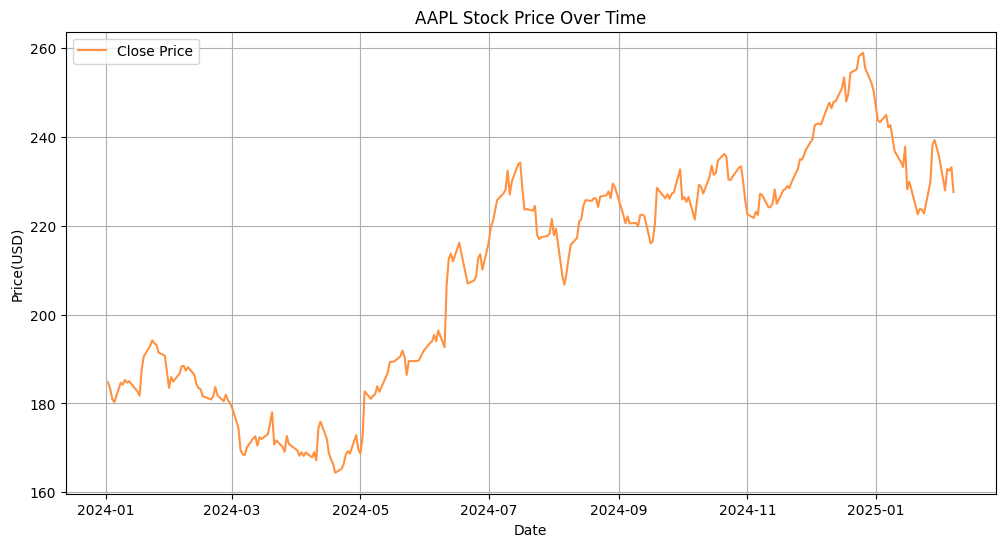

In [80]:
plt.figure(figsize=(12,6))
plt.plot(stock_data.index,stock_data.Close,label='Close Price',color='#FF9140')
plt.title("AAPL Stock Price Over Time")
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True)
plt.show()
          
    

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_additive = seasonal_decompose(stock_data["Close"],model='additive',period=30)

In [82]:
trend_additive=decomposition_additive.trend
seasonal_additive=decomposition_additive.seasonal
residual_additive=decomposition_additive.resid

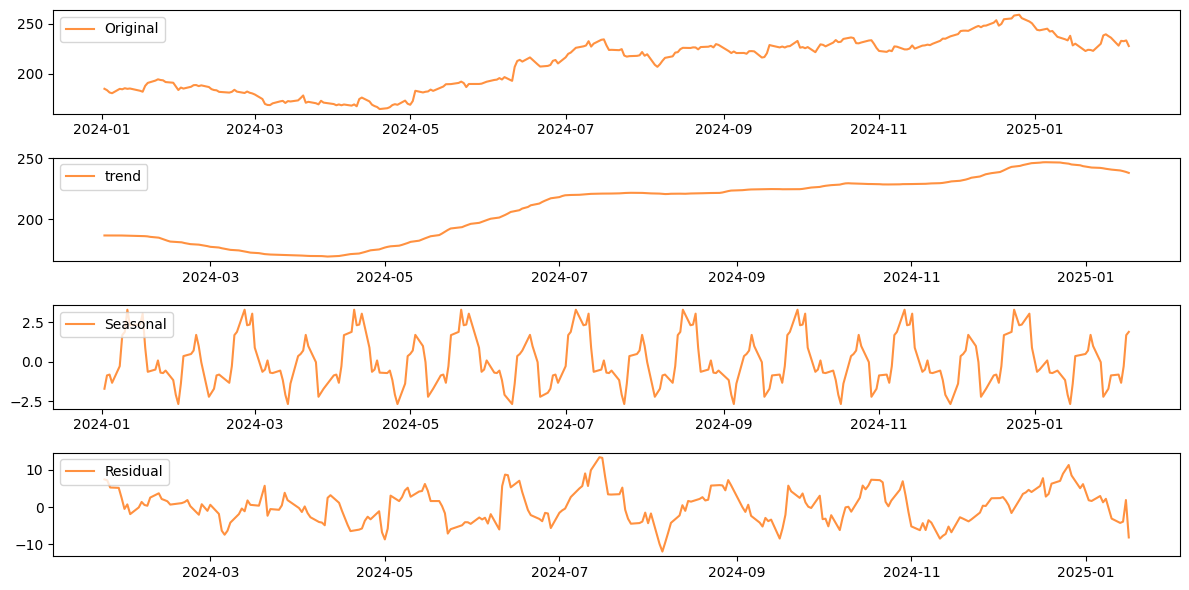

In [83]:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(stock_data.Close,label="Original",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(trend_additive,label="trend",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(seasonal_additive,label="Seasonal",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(residual_additive,label="Residual",color="#FF9140")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


# STL Decomposition using LOESS

In [84]:
from statsmodels.tsa.seasonal import STL

In [85]:
stl_decomposition=STL(stock_data["Close"],period=30)
result=stl_decomposition.fit()

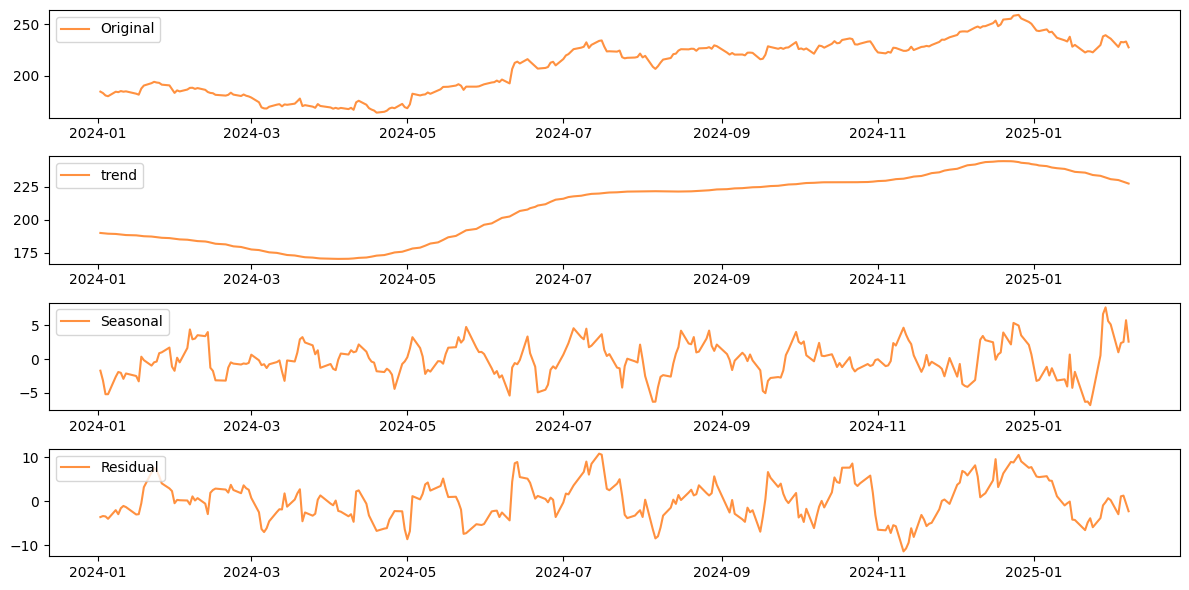

In [86]:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(result.observed,label="Original",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(result.trend,label="trend",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(result.seasonal,label="Seasonal",color="#FF9140")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(result.resid,label="Residual",color="#FF9140")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Tests for staionarity

In [89]:
from statsmodels.tsa.stattools import adfuller

adf_test=adfuller(stock_data.Close)

print("ADF Test Results")
print(f'ADF statistic: {round(adf_test[0],3)}')
print(f'Print p-value: {round(adf_test[1],3)}')
print("Critical Values")
for key,value in adf_test[4].items():
    print(f'Key:{key} and Value:{round(value,3)}')


ADF Test Results
ADF statistic: -1.084
Print p-value: 0.721
Critical Values
Key:1% and Value:-3.454
Key:5% and Value:-2.872
Key:10% and Value:-2.572


In [90]:
from statsmodels.tsa.stattools import kpss

kpss_test=kpss(stock_data.Close,regression='ct') # In regression we have 'c' for constant(Level Stationary), and 'ct for  trend

print('KPSS Test Results')

print(f'ADF statistic: {round(kpss_test[0],3)}')
print(f'Print p-value: {kpss_test[1]}')
print("Critical Values")
for key,value in kpss_test[3].items():
    print(f'Key:{key} and Value:{value}')


KPSS Test Results
ADF statistic: 0.191
Print p-value: 0.019467803200042405
Critical Values
Key:10% and Value:0.119
Key:5% and Value:0.146
Key:2.5% and Value:0.176
Key:1% and Value:0.216


# Strict Staitionarity

In [91]:
import numpy as np
import scipy.stats as ks_2samp
import matplotlib.pyplot as plt

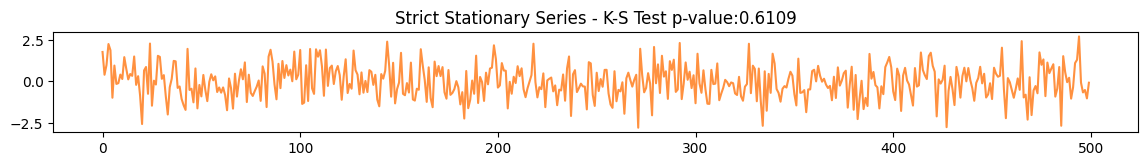

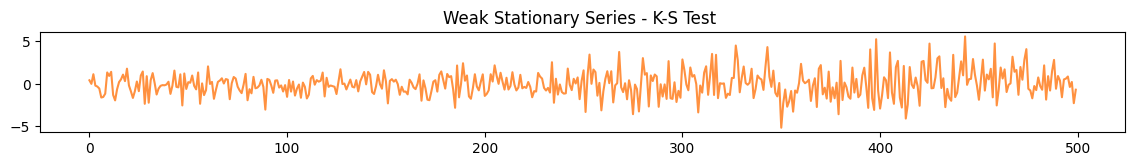

(0.068, 0.6109101078019121, 0.184, 0.00040888636357191906)

In [92]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

#generate synthetic data for demonstration 
np.random.seed(0)
n=500

#strict stationary series: normally distributed random noise
strict_stationary_series=np.random.normal(0,1,n)

#Non-strictly increasing stationary series
non_strict_stationary_series=np.concatenate(
   [ np.random.normal(0,1,n//2),
    np.random.normal(0,2,n//2)
   ]
)


# Function to split the  series into two halves and performs the K-S test

def ks_test_stationarity(series):
    split=len(series)//2
    series_first_half=series[:split]
    series_second_half=series[split:]
    stat,p_value=ks_2samp(series_first_half, series_second_half)
    return stat,p_value


# Perform K-S test on strict stationary Series
ks_stat_strict, ks_pvalue_strict=ks_test_stationarity(strict_stationary_series)

# Perform K-S test on non strict stationary Series
ks_stat_non_strict, ks_pvalue_non_strict=ks_test_stationarity(non_strict_stationary_series)

plt.figure(figsize=(14,6))
plt.subplot(411)
plt.title("Strict Stationary Series - K-S Test p-value:0.6109")
plt.plot(strict_stationary_series,color="#FF9140")
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(411)
plt.title("Weak Stationary Series - K-S Test ")
plt.plot(non_strict_stationary_series,color="#FF9140")
plt.show()

ks_stat_strict,ks_pvalue_strict, ks_stat_non_strict, ks_pvalue_non_strict


# Making Data Staionary


In [93]:
# Performing ADF and KPSS tests
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics:',result[0])
    print('p-value:',result[1])
    for key,value in result[4].items():
        print('Critical Value (%s): %.3f' % (key,value))

def kpss_test(series):
    result=kpss(series,regression='c')
    print('KPSS Staistics:', result[0])
    print('p-value:',result[1])
    for key,value in result[3].items():
        print('Critical Value (%s): %.3f' % (key,value))

In [94]:
prices=stock_data['Close']

In [95]:
adf_test(prices)

ADF Statistics: -1.0844464669646723
p-value: 0.7212344525691927
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


In [96]:
kpss_test(prices)

KPSS Staistics: 2.2297866283993217
p-value: 0.01
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739


In [106]:
prices.columns
#prices
prices1=prices['AAPL']

In [120]:
# 1st order differencing
prices_diff=prices1.diff()

In [110]:
#second order differencing
prices1.diff().diff()

Date
2024-01-02          NaN
2024-01-03          NaN
2024-01-04    -0.945343
2024-01-05     1.602127
2024-01-08     5.085114
                ...    
2025-02-03    -6.400009
2025-02-04    12.780014
2025-02-05    -5.120010
2025-02-06     1.080002
2025-02-07    -6.339996
Name: AAPL, Length: 277, dtype: float64

# Transformation

In [111]:
import numpy as np
from scipy import stats

#Log transformation
prices_log=np.log(prices1)

#Power transformation(Square root transoformation)
prices_square_root=np.sqrt(prices1)

#Box-Cox  transformation
#Note: Box-Cox requires all positive values
prices_boxcox, lam=stats.boxcox(prices1[prices1>0])

In [116]:
prices_log
adf_test(prices_log)

ADF Statistics: -1.0464818776199278
p-value: 0.7359360524979944
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


In [117]:
prices_square_root
adf_test(prices_square_root)

ADF Statistics: -1.0638445253457698
p-value: 0.7292729060243686
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


In [119]:
prices_boxcox
adf_test(prices_boxcox)

ADF Statistics: -1.122516818288835
p-value: 0.7060094455660088
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


In [122]:
adf_test(prices_diff.dropna())

ADF Statistics: -15.781291168617797
p-value: 1.1303555402505282e-28
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


# Making data staionary by detrending

In [183]:
from scipy import signal


#using a linear trend

trend = np.polyfit(np.arange(len(prices1)),prices1,1)
trendline=np.polyval(trend,np.arange(len(prices1)))
prices_detrended=prices1-trendline


NameError: name 'prices1' is not defined

In [136]:
adf_test(prices_detrended)

ADF Statistics: -0.23197892303591283
p-value: 0.9346009098171929
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


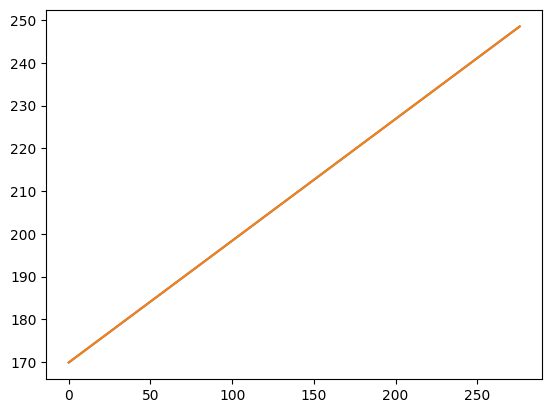

In [142]:
plt.plot(np.arange(len(prices1)),trendline)
plt.plot(np.arange(len(prices1)),prices1)
plt.show()

In [132]:
type(prices1)

pandas.core.series.Series

In [128]:
#Using a moving average to remove trend(window)
window=12 #window size
prices_ma=prices1.rolling(window=window).mean()
prices_detrended=prices1-prices_ma
prices_detrended.dropna()



Date
2024-01-18    3.917479
2024-01-19    6.342262
2024-01-22    7.861479
2024-01-23    8.044759
2024-01-24    6.263474
                ...   
2025-02-03   -2.009171
2025-02-04    2.402504
2025-02-05    1.865002
2025-02-06    1.733335
2025-02-07   -4.173328
Name: AAPL, Length: 266, dtype: float64

In [145]:
adf_test(prices_detrended)

ADF Statistics: -0.23197892303591283
p-value: 0.9346009098171929
Critical Value (1%): -3.454
Critical Value (5%): -2.872
Critical Value (10%): -2.572


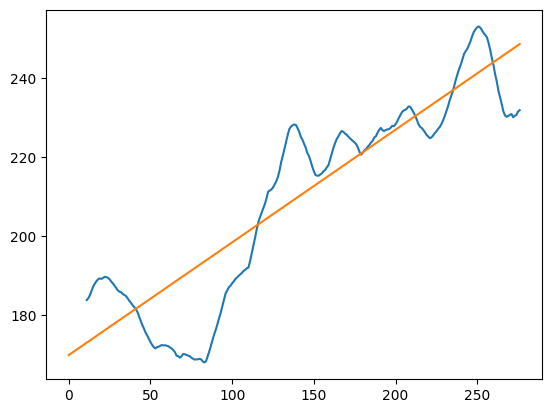

In [143]:
plt.plot(np.arange(len(prices1)),prices_ma)
plt.plot(np.arange(len(prices1)),prices1)
plt.show()

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose
#seasonal decomposition using moving averages
decomposition=seasonal_decompose(prices1,model='additive',period=30)
prices_adjusted=prices1/decomposition.seasonal
prices_adjusted = prices_adjusted.dropna()
prices_adjusted



Date
2024-01-02   -107.748803
2024-01-03   -210.571870
2024-01-04   -221.268434
2024-01-05   -134.680277
2024-01-08   -644.619508
                 ...    
2025-02-03   -278.701430
2025-02-04   -173.899842
2025-02-05   -811.537199
2025-02-06    138.947529
2025-02-07    120.853966
Length: 277, dtype: float64

In [144]:
adf_test(prices_adjusted)

ADF Statistics: -8.57448122688119
p-value: 8.031876436397547e-14
Critical Value (1%): -3.456
Critical Value (5%): -2.873
Critical Value (10%): -2.573


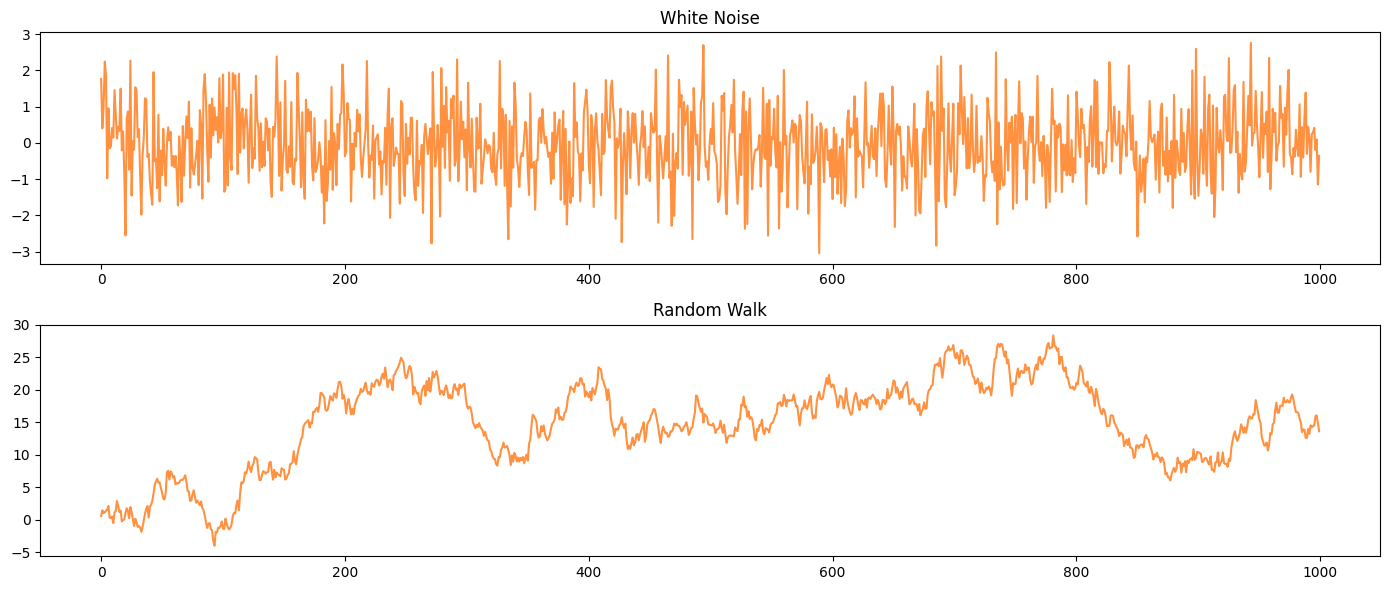


Ljung Box Test for white Noise
      lb_stat  lb_pvalue
10  14.025574   0.171828

Ljung-Box for Random Walk
        lb_stat  lb_pvalue
10  8828.660312        0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

np.random.seed(0)
n=1000

#White Noise
white_noise=np.random.normal(0,1,n)

#Random Walk
random_shocks=np.random.normal(0,1,n)
random_walk=np.cumsum(random_shocks)

#Plotting the series
plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(white_noise,color="#FF9140")
plt.title(f'White Noise')

plt.subplot(2,1,2)
plt.plot(random_walk,color="#FF9140")
plt.title(f'Random Walk')

plt.tight_layout()
plt.show()


#Ljung-Box test
print("\nLjung Box Test for white Noise")
lb_test_white_noise=acorr_ljungbox(white_noise,lags=[10],return_df=True)
print(lb_test_white_noise)

print("\nLjung-Box for Random Walk")
lb_test_random_walk = acorr_ljungbox(random_walk,lags=[10],return_df=True)
print(lb_test_random_walk)



# Time Series Forecasting Models

In [60]:
# making data stationary before model fitting

stock_data = yf.download('AAPL',start='2023-01-01')

apple_price_stationary=stock_data.Close.diff().dropna()

#split the data into training and testing datasets
train_data, test_data=apple_price_stationary[:-30],apple_price_stationary[-30:]



*********************100%***********************]  1 of 1 completed

In [61]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,123.632530,129.395518,122.742873,128.782649,112117500
2023-01-04,124.907715,127.181283,123.642427,125.431622,89113600
2023-01-05,123.583099,126.301493,123.326093,125.668849,80962700
2023-01-06,128.130219,128.792516,123.454587,124.561717,87754700
2023-01-09,128.654160,131.876702,128.397153,128.970489,70790800
...,...,...,...,...,...
2025-02-05,232.214691,232.414468,228.019307,228.279016,39620300
2025-02-06,232.963867,233.543232,230.176923,231.035979,29925300


# AR Model 

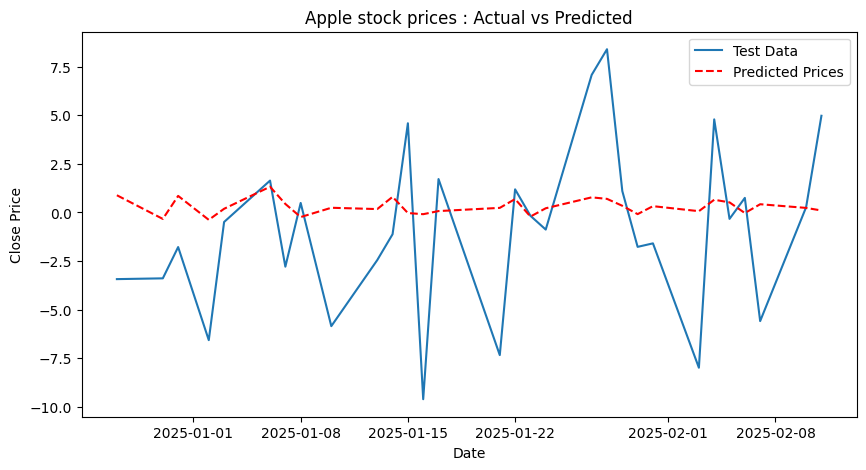

RMSE__ 43.0


In [62]:


from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Fit the Autoregressive model(AR) to the training data
model = AutoReg(train_data,lags=30)
model_fit=model.fit()

#make predictions on the test data
predictions = model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False
 )

#Plot the actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_data.index,test_data,label='Test Data')
plt.plot(test_data.index,predictions,color='red',linestyle='--',label='Predicted Prices')
plt.title('Apple stock prices : Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#evaluates model using RMSE score
rmse = round(np.sqrt(mean_squared_error(test_data,predictions)),2)
print('RMSE__',rmse*10)

# MA Model

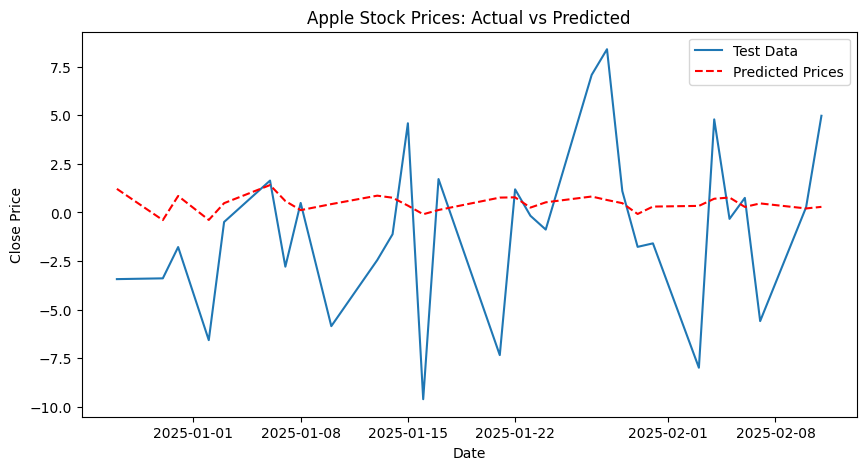

RMSE: 4.37


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_data, order=(0, 0, 30))  # MA model with 30 lags
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

# Plot the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label="Predicted Prices")
plt.title('Apple Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = round(np.sqrt(mean_squared_error(test_data, predictions)), 2)
print('RMSE:', rmse)


# ARMA Model

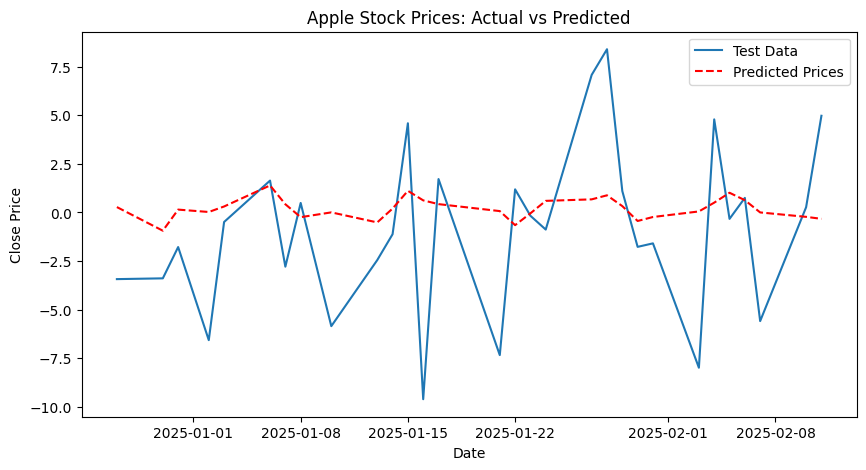

RMSE: 4.25


In [64]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_data, order=(7, 0, 7))  # MA model with 30 lags
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

# Plot the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label="Predicted Prices")
plt.title('Apple Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = round(np.sqrt(mean_squared_error(test_data, predictions)), 2)
print('RMSE:', rmse)


# ARIMA Model

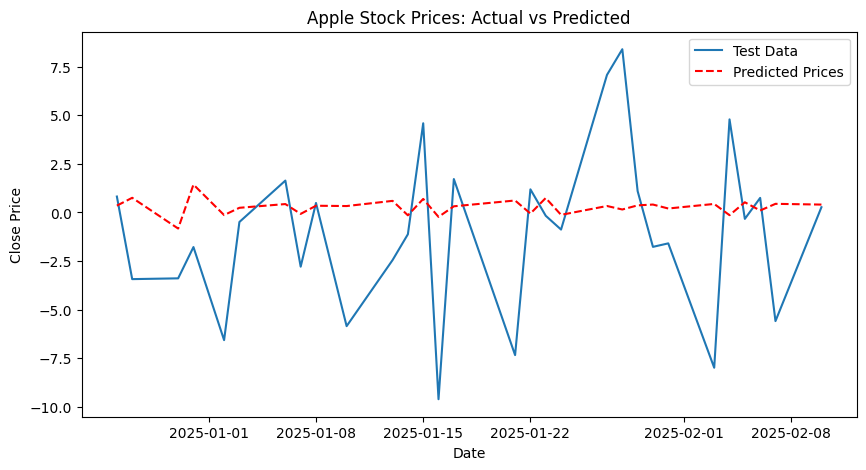

RMSE: 4.32


In [25]:
# Fit the Moving Average (MA) model to the training data
model = ARIMA(train_data, order=(7, 1, 7))  
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

# Plot the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label="Predicted Prices")
plt.title('Apple Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = round(np.sqrt(mean_squared_error(test_data, predictions)), 2)
print('RMSE:', rmse)

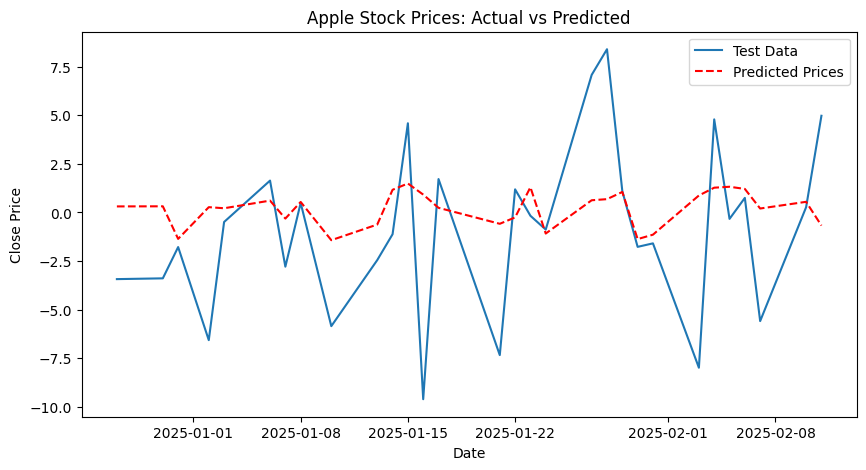

RMSE: 4.25


In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p,d,q=7,1,7
P,D,Q,s=1,1,1,45

#Fit the SARIMA Model
model = SARIMAX(train_data,order=(p,d,q),seasonal_order=(P,D,Q,s))
model_fit=model.fit()

#Make predictions on the test data
predictions=model_fit.predict(
    start=len(train_data),
    end=len(train_data)+ len(test_data)-1,
    dynamic=False
)

#Plot the actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions, color='red', linestyle='--', label="Predicted Prices")
plt.title('Apple Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = round(np.sqrt(mean_squared_error(test_data, predictions)), 2)
print('RMSE:', rmse)

              

In [71]:
stock_data['Open']

Ticker,AAPL
Date,
2023-01-03,128.782649
2023-01-04,125.431622
2023-01-05,125.668849
2023-01-06,124.561717
2023-01-09,128.970489
...,...
2025-02-05,228.279016
2025-02-06,231.035979
2025-02-07,232.344548


# Vector Models

In [72]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Download Tesla (TSLA) stock data
tsla_data = yf.download('TSLA', start='2023-01-01')
tsla_data = tsla_data[['Close']].rename(columns={'Close': 'TSLA_Close'})

# Download Apple (AAPL) stock data
aapl_data = yf.download('AAPL', start='2023-01-01')
aapl_data = aapl_data[['Close']].rename(columns={'Close': 'AAPL_Close'})

# Merge both datasets on date
#stock_data = tsla_data.merge(aapl_data, left_index=True, right_index=True, how='inner')

# Shift Apple's closing price to align with the next day's Tesla price
stock_data['AAPL_Close_Lagged'] = stock_data['AAPL_Close'].shift()

# Drop NaN values (from shifting)
stock_data.dropna(inplace=True)

# Perform Granger-Causality test
grangercausalitytests(stock_data[['TSLA_Close', 'AAPL_Close_Lagged']], maxlag=[14])

print("Granger Causality Test Completed")




*********************100%***********************]  1 of 1 completed

KeyError: 'AAPL_Close'

In [73]:
tsla_data=yf.download('TSLA',start='2023-01-01')

stock_data['TSLA_Close']=tsla_data['Close']
stock_data['AAPL_Close']=stock_data['Close'].shift()
stock_data.dropna(inplace=True)

from statsmodels.tsa.stattools import grangercausalitytests

#perform Gamger-Causality test
grangercausalitytests(stock_data[['AAPL_Close','TSLA_Close']].dropna(),maxlag=14)
print()

[*********************100%***********************]  1 of 1 completed


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2775  , p=0.5986  , df_denom=524, df_num=1
ssr based chi2 test:   chi2=0.2791  , p=0.5973  , df=1
likelihood ratio test: chi2=0.2790  , p=0.5973  , df=1
parameter F test:         F=0.2775  , p=0.5986  , df_denom=524, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=38.6228 , p=0.0000  , df_denom=521, df_num=2
ssr based chi2 test:   chi2=77.9869 , p=0.0000  , df=2
likelihood ratio test: chi2=72.7202 , p=0.0000  , df=2
parameter F test:         F=38.6228 , p=0.0000  , df_denom=521, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=25.6791 , p=0.0000  , df_denom=518, df_num=3
ssr based chi2 test:   chi2=78.0783 , p=0.0000  , df=3
likelihood ratio test: chi2=72.7906 , p=0.0000  , df=3
parameter F test:         F=25.6791 , p=0.0000  , df_denom=518, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=19.2301 , p=0.0000  

In [74]:
stock_data

Price,Close,High,Low,Open,Volume,TSLA_Close,AAPL_Close
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2023-01-04,124.907715,127.181283,123.642427,125.431622,89113600,113.639999,123.632530
2023-01-05,123.583099,126.301493,123.326093,125.668849,80962700,110.339996,124.907715
2023-01-06,128.130219,128.792516,123.454587,124.561717,87754700,113.059998,123.583099
2023-01-09,128.654160,131.876702,128.397153,128.970489,70790800,119.769997,128.130219
2023-01-10,129.227463,129.751370,126.647460,128.762863,63896200,118.849998,128.654160
...,...,...,...,...,...,...,...
2025-02-05,232.214691,232.414468,228.019307,228.279016,39620300,378.170013,232.544327
2025-02-06,232.963867,233.543232,230.176923,231.035979,29925300,374.320007,232.214691


In [94]:
data=stock_data[['AAPL_Close','TSLA_Close']].diff().dropna()

In [95]:
type(data)

pandas.core.frame.DataFrame

In [96]:
data.columns

MultiIndex([('AAPL_Close', ''),
            ('TSLA_Close', '')],
           names=['Price', 'Ticker'])

In [97]:
data.reset_index(inplace=True)


In [107]:
data1=data


In [108]:
data1.reset_index(inplace=True)

In [118]:
data1.columns = data1.columns.get_level_values(0)

In [124]:
data1.drop(columns='index',axis=1,inplace=True)
data1.columns

Index(['Date', 'AAPL_Close', 'TSLA_Close'], dtype='object', name='Price')

In [125]:
data1.set_index('Date',inplace=True)

In [128]:
data1.dropna()

Price,AAPL_Close,TSLA_Close
Date,,
2023-01-05,1.275185,-3.300003
2023-01-06,-1.324615,2.720001
2023-01-09,4.547119,6.709999
2023-01-10,0.523941,-0.919998
2023-01-11,0.573303,4.370003
...,...,...
2025-02-05,4.784744,-14.039978
2025-02-06,-0.329636,-3.850006
2025-02-07,0.749176,-12.700012


In [127]:
data1.columns

Index(['AAPL_Close', 'TSLA_Close'], dtype='object', name='Price')

In [ ]:
train_

In [86]:
data

Price,AAPL_Close,TSLA_Close
Ticker,,
Date,,
2023-01-05,1.275185,-3.300003
2023-01-06,-1.324615,2.720001
2023-01-09,4.547119,6.709999
2023-01-10,0.523941,-0.919998
2023-01-11,0.573303,4.370003
...,...,...
2025-02-05,4.784744,-14.039978
2025-02-06,-0.329636,-3.850006


In [129]:
train_data,test_data=data1[:-14],data1[-14:]

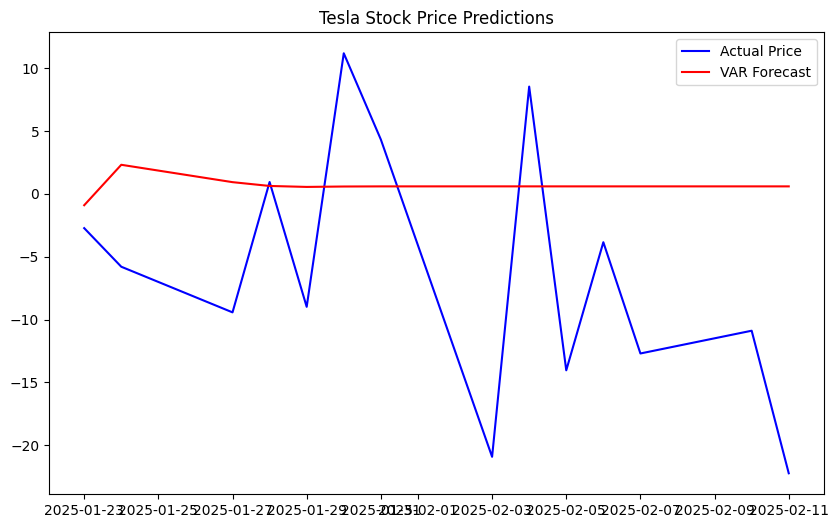

RMSE -- 11.9


In [133]:
from statsmodels.tsa.api import VAR,VARMAX

# VAR
model = VAR(train_data)
result= model.fit(maxlags=2)
predictions=result.forecast(train_data.values[-result.k_ar:],steps=len(test_data))

predictions = pd.DataFrame(predictions,index=test_data.index,columns=test_data.columns)
plt.figure(figsize=(10,6))
plt.plot(test_data.index,test_data['TSLA_Close'],label='Actual Price',color='blue')
plt.plot(test_data.index,predictions['TSLA_Close'],label='VAR Forecast',color='red')
plt.legend()
plt.title('Tesla Stock Price Predictions')
plt.show()

#rmse
rmse=round(np.sqrt(mean_squared_error(test_data['TSLA_Close'],predictions['TSLA_Close'])),2)
print('RMSE --',rmse)

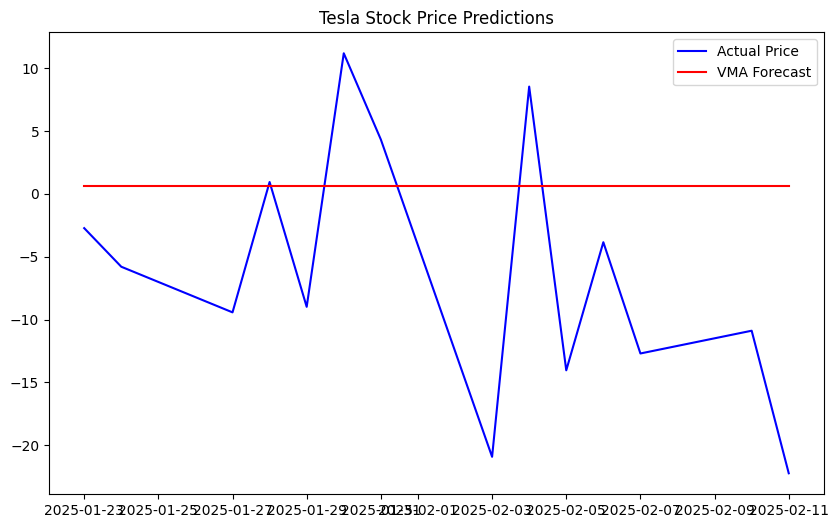

RMSE -- 11.83


In [134]:
# VMA
model = VARMAX(train_data,order=(0,14))
result= model.fit()
predictions=result.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False
)
    
plt.figure(figsize=(10,6))
plt.plot(test_data.index,test_data['TSLA_Close'],label='Actual Price',color='blue')
plt.plot(test_data.index,predictions['TSLA_Close'],label='VMA Forecast',color='red')
plt.legend()
plt.title('Tesla Stock Price Predictions')
plt.show()

#rmse
rmse=round(np.sqrt(mean_squared_error(test_data['TSLA_Close'],predictions['TSLA_Close'])),2)
print('RMSE --',rmse)

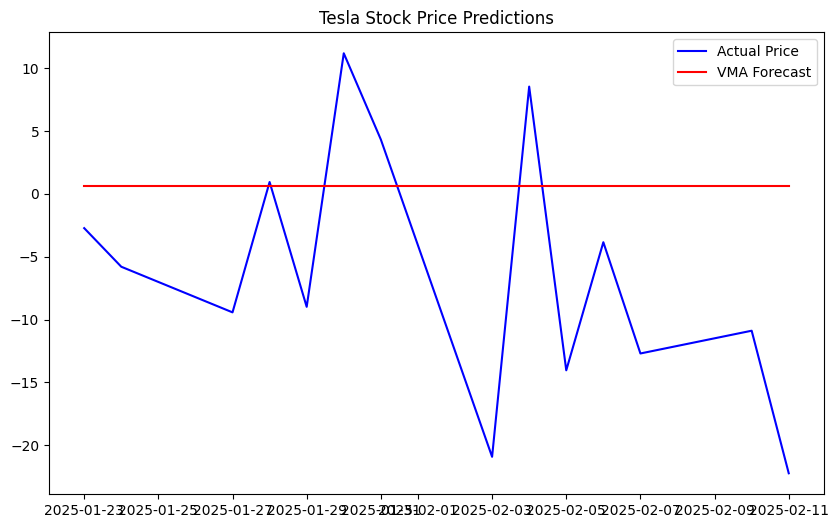

RMSE -- 11.83


In [135]:
# VARIMA
model = VARMAX(train_data,order=(14,14))
result= model.fit()
predictions=result.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False
)
    
plt.figure(figsize=(10,6))
plt.plot(test_data.index,test_data['TSLA_Close'],label='Actual Price',color='blue')
plt.plot(test_data.index,predictions['TSLA_Close'],label='VMA Forecast',color='red')
plt.legend()
plt.title('Tesla Stock Price Predictions')
plt.show()

#rmse
rmse=round(np.sqrt(mean_squared_error(test_data['TSLA_Close'],predictions['TSLA_Close'])),2)
print('RMSE --',rmse)

In [144]:
stock_data['Close']['AAPL']

Date
2023-01-04    124.907715
2023-01-05    123.583099
2023-01-06    128.130219
2023-01-09    128.654160
2023-01-10    129.227463
                 ...    
2025-02-05    232.214691
2025-02-06    232.963867
2025-02-07    227.380005
2025-02-10    227.649994
2025-02-11    232.619995
Name: AAPL, Length: 528, dtype: float64

# Smoothing Methods

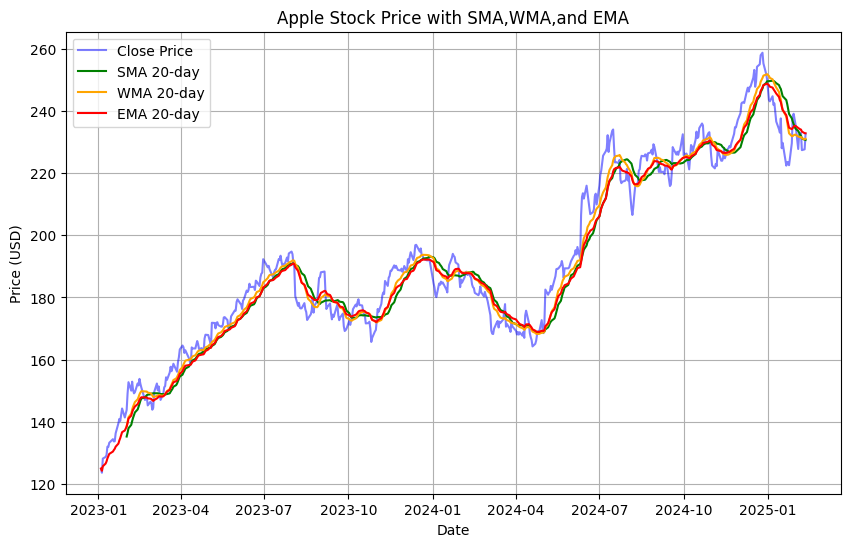

In [145]:
#Moving Averages
window_size=20
stock_data['SMA']=stock_data['Close']['AAPL'].rolling(window=window_size).mean()


# Calculate Weighted Moving Average(WMA)
weights = np.arange(1,window_size+1)
stock_data['WMA']=stock_data['Close']['AAPL'].rolling(window_size).apply(lambda prices:np.dot(prices,weights)/weights.sum(),raw=True)

#Calculate Exponential Moving Average(EMA)
stock_data['EMA']=stock_data['Close']['AAPL'].ewm(span=window_size).mean()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(stock_data['Close'],label='Close Price', color='blue',alpha=0.5)
plt.plot(stock_data['SMA'],label=f'SMA {window_size}-day',color='green')
plt.plot(stock_data['WMA'],label=f'WMA {window_size}-day',color='orange')
plt.plot(stock_data['EMA'],label=f'EMA {window_size}-day',color='red')

plt.title('Apple Stock Price with SMA,WMA,and EMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


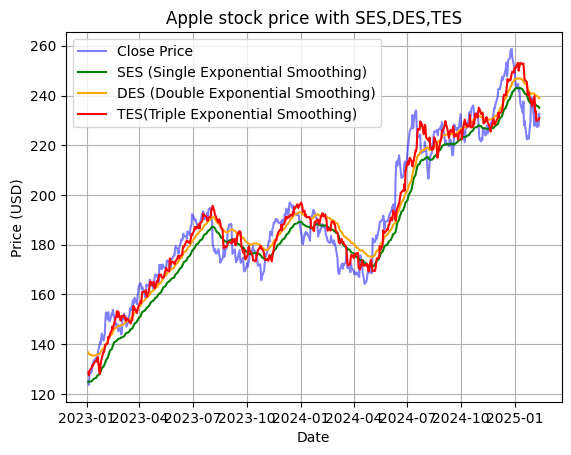

In [154]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Single Exponential Smoothing
close_prices = stock_data['Close']
ses_model = SimpleExpSmoothing(close_prices).fit(smoothing_level=0.05)
stock_data['SES']=ses_model.fittedvalues

#Double Exponential Smoothing (DES) - Holt's linear trend model
des_model=ExponentialSmoothing(close_prices,trend='add').fit(smoothing_level=0.05)
stock_data['DES']=des_model.fittedvalues

# Triple Exponential Smoothing
tes_model = ExponentialSmoothing(close_prices,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.05)
stock_data['TES']=tes_model.fittedvalues

# Plotting
plt.figure
plt.plot(stock_data.Close,label='Close Price',color='blue',alpha=0.5)
plt.plot(stock_data.SES,label='SES (Single Exponential Smoothing)',color='green')
plt.plot(stock_data.DES,label='DES (Double Exponential Smoothing)',color='orange')
plt.plot(stock_data.TES,label='TES(Triple Exponential Smoothing)',color='red')

plt.title('Apple stock price with SES,DES,TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()
          

# ACF and PACF Plots

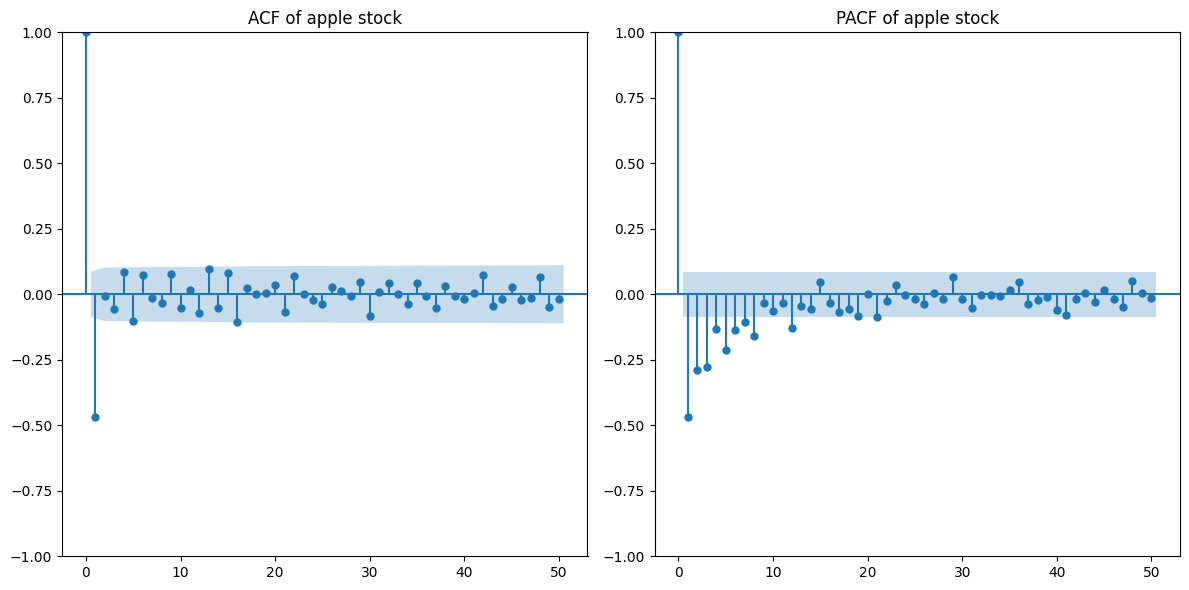

In [157]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure(figsize=(12,6))

# ACF Plot
plt.subplot(1,2,1)
plot_acf(stock_data['Close'].diff().diff().dropna(),ax=plt.gca(),lags=50)
plt.title('ACF of apple stock')

# PACF Plot
plt.subplot(1,2,2)
plot_pacf(stock_data['Close'].diff().diff().dropna(),ax=plt.gca(),lags=50,method='ywm')
plt.title('PACF of apple stock')

plt.tight_layout()
plt.show()        


# Model Evaluation Metrics

In [160]:
train_data,test_data=apple_price_stationary[:-30],apple_price_stationary[-30:]

# Fit the Auto regressive model (AR) to the training data
model = AutoReg(train_data,lags=30)
model_fit=model.fit()

#Make predictions on the test data
predictions=model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) -1,
    dynamic=False)


In [170]:
type(list(test_data))

list

In [172]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# 1. Mean Absolute Error(MAE)
mae=mean_absolute_error(test_data,predictions)
print(f'Mean Absolute Error(MAE): {mae}')

# 2. Mean Square Error
mse = mean_squared_error(test_data,predictions)
print(f'Mean Squared Error(MSE): {mse}')
#3. Root Mean Squared Error
rmse = np.sqrt(mse)
print(f'(Root Mean Squared Error:{rmse}')

# 4. Mean absolute Percentage Error(MAPE)
mape = np.mean(np.abs((list(test_data)-predictions)/list(test_data)))*100
print(f'Mean Absolute Percentage Error: {mape}%')

#AIC & BIC

aic= model_fit.aic
bic=model_fit.bic

print(f'Alike Information Criteria (AIC): {aic}')
print(f'Bayesian Information Criteria (BIC):{bic}') 

Mean Absolute Error(MAE): 3.3260213433914756
Mean Squared Error(MSE): 18.470530164121904
(Root Mean Squared Error:4.297735469304958


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

In [173]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# 4. Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(test_data) - np.array(predictions)) / np.array(test_data))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# AIC & BIC (Ensure model_fit is defined)
aic = model_fit.aic
bic = model_fit.bic

print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Bayesian Information Criterion (BIC): {bic}')


Mean Absolute Error (MAE): 3.3260213433914756
Mean Squared Error (MSE): 18.470530164121904
Root Mean Squared Error: 4.297735469304958
Mean Absolute Percentage Error (MAPE): 112.53%
Akaike Information Criterion (AIC): 2241.168315338016
Bayesian Information Criterion (BIC): 2373.9193008073808


In [174]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure test_data and predictions are numeric NumPy arrays
test_data = np.array(test_data, dtype=np.float64)
predictions = np.array(predictions, dtype=np.float64)

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# 4. Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# AIC & BIC (Ensure model_fit is defined)
aic = model_fit.aic
bic = model_fit.bic

print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Bayesian Information Criterion (BIC): {bic}')


Mean Absolute Error (MAE): 3.3260213433914756
Mean Squared Error (MSE): 18.470530164121904
Root Mean Squared Error: 4.297735469304958
Mean Absolute Percentage Error (MAPE): 112.53%
Akaike Information Criterion (AIC): 2241.168315338016
Bayesian Information Criterion (BIC): 2373.9193008073808


In [180]:
model = AutoReg(train_data,lags=20)
model_fit=model.fit()

# make predictions on the test data
predictions = model_fit.predict(
     start = len(train_data),
     end=len(train_data) + len(test_data) -1,
    dynamic=False
)

# 1. Mean Absolute Error(MAE)
mae = mean_absolute_error(test_data,predictions)
print(f'Mean absolute error(MAE): {mae}')

# 2. Mean Squared Error(MSE)
mse = mean_squared_error(test_data,predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error(RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


mape = np.mean(np.abs((np.array(test_data) - np.array(predictions)) / np.array(test_data))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


# # 4. Mean aboslute percentage error(MAPE)
# mape = np.mean(np.abs((test_data-predictions)/test_data))*100
# print(f'Mean absolute percentage error (MAPE): {mape}')



Mean absolute error(MAE): 3.306967929327887
Mean Squared Error (MSE): 18.518846694224774
Root Mean Squared Error (RMSE): 4.30335295952177
Mean Absolute Percentage Error (MAPE): 107.48%


# Data Preprocessing of Time Series Data
# 1. Handling missing Values : Date with no values, Date is not present
# 2. Making data Stationary
# 3. Handling outliers
# 4. Resampling

In [210]:
data = {
    'Date':['2024-01-01','2024-01-02','2024-01-04','2024-01-07','2024-01-08','2024-01-09','2024-01-10','2024-01-12'],
    'Price':[100,101,103,106,107,108,109,111]
}

#create a dataframe
data =pd.DataFrame(data)
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

data

,Price
Date,
2024-01-01,100
2024-01-02,101
2024-01-04,103
2024-01-07,106
2024-01-08,107
2024-01-09,108
2024-01-10,109
2024-01-12,111


In [211]:
# Create a complete date range
complete_index=pd.date_range(start='2024-01-01',end='2024-01-12',freq='D')
data = data.reindex(complete_index)
print("Reindexed DataFrame with Missing Dates: \n",data)


Reindexed DataFrame with Missing Dates: 
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03    NaN
2024-01-04  103.0
2024-01-05    NaN
2024-01-06    NaN
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11    NaN
2024-01-12  111.0


In [212]:
# Mean Imputation
mean_value = data.mean()
data_mean_imputed=data.fillna(mean_value)

# Median Imputation
median_value = data.median()
data_median_imputed = data.fillna(median_value)

# Mode Imputation
mode_value = data.mode()
data_mode_imputed = data.fillna(mode_value.values[0][0])

# Forward Fill
data_ffill = data.ffill()

# Backward Fill
data_bfill = data.bfill()

print("Original Data:\n",data)
print('_________________________\nMean',mean_value.values[0])
print('___________________________\nMean Imputation:\n', data_mean_imputed)


print('_________________________\nMdian',median_value.values[0])
print('___________________________\nMedian Imputation:\n', data_median_imputed)

print('_________________________\nMode',mode_value.values[0][0])
print('___________________________\nMode Imputation:\n', data_mode_imputed)

Original Data:
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03    NaN
2024-01-04  103.0
2024-01-05    NaN
2024-01-06    NaN
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11    NaN
2024-01-12  111.0
_________________________
Mean 105.625
___________________________
Mean Imputation:
               Price
2024-01-01  100.000
2024-01-02  101.000
2024-01-03  105.625
2024-01-04  103.000
2024-01-05  105.625
2024-01-06  105.625
2024-01-07  106.000
2024-01-08  107.000
2024-01-09  108.000
2024-01-10  109.000
2024-01-11  105.625
2024-01-12  111.000
_________________________
Mdian 106.5
___________________________
Median Imputation:
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03  106.5
2024-01-04  103.0
2024-01-05  106.5
2024-01-06  106.5
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11  106.5
2024-01-12  111.0
_________________________
Mode 100.0
___________________________
Mode Imputation:
   

# Inerpolation

In [213]:
#Linear Interpolation
data_linear_interp = data.interpolate(method='linear')

#Polynomial Interpolation(degree 2)
data_poly_interp = data.interpolate(method='polynomial',order=2)

# Spline Interpolation (order 2)
data_spline_interp=data.interpolate(method='spline',order=2)

print("\n Linear Interpolation:\n", data_linear_interp)
print("\n Polynomial Interpolation: \n",data_poly_interp)
print("\n Spline Interpolation: \n", data_spline_interp)



 Linear Interpolation:
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03  102.0
2024-01-04  103.0
2024-01-05  104.0
2024-01-06  105.0
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11  110.0
2024-01-12  111.0

 Polynomial Interpolation: 
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03  102.0
2024-01-04  103.0
2024-01-05  104.0
2024-01-06  105.0
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11  110.0
2024-01-12  111.0

 Spline Interpolation: 
             Price
2024-01-01  100.0
2024-01-02  101.0
2024-01-03  102.0
2024-01-04  103.0
2024-01-05  104.0
2024-01-06  105.0
2024-01-07  106.0
2024-01-08  107.0
2024-01-09  108.0
2024-01-10  109.0
2024-01-11  110.0
2024-01-12  111.0


In [214]:
data['Sales'] = [700,900,1000,2000,1500,3000,2300,4000,5900,6000,65000,7000]
data

,Price,Sales
2024-01-01,100.0,700
2024-01-02,101.0,900
2024-01-03,NaN,1000
2024-01-04,103.0,2000
2024-01-05,NaN,1500
2024-01-06,NaN,3000
2024-01-07,106.0,2300
2024-01-08,107.0,4000
2024-01-09,108.0,5900
2024-01-10,109.0,6000


In [216]:
from sklearn.linear_model import LinearRegression

known_data = data.dropna(subset=['Price'])
missing_data = data[data['Price'].isna()]

#Train a model
model = LinearRegression()
model.fit(known_data[['Sales']],known_data['Price'])

#Predict missing values
predicted_values=model.predict(missing_data[['Sales']])
data.loc[data['Price'].isna(),'Price']=predicted_values

print("\n Data with predicted Values:\n",data) 


 Data with predicted Values:
                  Price  Sales
2024-01-01  100.000000    700
2024-01-02  101.000000    900
2024-01-03  101.675094   1000
2024-01-04  103.000000   2000
2024-01-05  102.434691   1500
2024-01-06  104.713483   3000
2024-01-07  106.000000   2300
2024-01-08  107.000000   4000
2024-01-09  108.000000   5900
2024-01-10  109.000000   6000
2024-01-11  198.903558  65000
2024-01-12  111.000000   7000


In [198]:
known_data

,Price,Sales
2024-01-01,100.0,700
2024-01-02,101.0,900
2024-01-04,103.0,2000
2024-01-07,106.0,2300
2024-01-08,107.0,4000
2024-01-09,108.0,5900
2024-01-10,109.0,6000
2024-01-12,111.0,7000


# Resampling

In [218]:
# Downsampling
monthly_data = stock_data['Close'].resample('M').mean()
print("\n Monthly Downsampled Data:\n",monthly_data)


 Monthly Downsampled Data:
 Ticker            AAPL
Date                  
2023-01-31  134.775599
2023-02-28  149.376950
2023-03-31  153.417605
2023-04-30  163.397964
2023-05-31  171.039942
2023-06-30  182.695788
2023-07-31  190.753935
2023-08-31  179.680433
2023-09-30  175.714644
2023-10-31  173.397758
2023-11-30  184.692047
2023-12-31  193.148856
2024-01-31  186.603933
2024-02-29  183.835622
2024-03-31  171.884886
2024-04-30  168.807460
2024-05-31  185.584774
2024-06-30  205.572249
2024-07-31  223.846307
2024-08-31  221.073107
2024-09-30  223.266615
2024-10-31  229.550871
2024-11-30  227.498904
2024-12-31  249.049032
2025-01-31  234.329359
2025-02-28  230.447495


In [219]:
#Upsampling
hourly_data = stock_data['Close'].resample('H').interpolate(mehtod='linear')
print('\n Hourly Upsampled Date:\n',hourly_data)


 Hourly Upsampled Date:
 Ticker                     AAPL
Date                           
2023-01-04 00:00:00  124.907715
2023-01-04 01:00:00  124.852523
2023-01-04 02:00:00  124.797330
2023-01-04 03:00:00  124.742138
2023-01-04 04:00:00  124.686946
...                         ...
2025-02-10 20:00:00  231.791662
2025-02-10 21:00:00  231.998745
2025-02-10 22:00:00  232.205828
2025-02-10 23:00:00  232.412912
2025-02-11 00:00:00  232.619995

[18457 rows x 1 columns]
